In [2]:
import pandas as pd
wed = pd.read_csv("Wednesday.csv")

In [2]:
print(wed[wed['station_complex_id'] == 'R185'])

          transit_timestamp station_complex_id station_complex borough routes  \
140     2022-06-15 00:00:00               R185      191 St (1)       M      1   
226600  2022-02-16 15:00:00               R185      191 St (1)       M      1   
226601  2022-05-04 21:00:00               R185      191 St (1)       M      1   
226602  2023-06-07 18:00:00               R185      191 St (1)       M      1   
226603  2022-12-07 13:00:00               R185      191 St (1)       M      1   
...                     ...                ...             ...     ...    ...   
234171  2023-09-06 19:00:00               R185      191 St (1)       M      1   
234184  2023-08-02 21:00:00               R185      191 St (1)       M      1   
234207  2023-07-26 03:00:00               R185      191 St (1)       M      1   
234219  2023-08-09 21:00:00               R185      191 St (1)       M      1   
234220  2023-09-20 11:00:00               R185      191 St (1)       M      1   

       payment_method  ride

In [3]:
wed['transit_timestamp'] = pd.to_datetime(wed['transit_timestamp'])
filtered_df = wed[(wed['transit_timestamp'].dt.time >= pd.to_datetime('7:00:00').time()) &
                  (wed['transit_timestamp'].dt.time <= pd.to_datetime('9:00:00').time())]
test = filtered_df[(filtered_df['routes'].str.contains("1"))|(filtered_df['routes'].str.contains("2"))]

In [4]:
print(test[test['station_complex_id'] == 'R185'])

         transit_timestamp station_complex_id station_complex borough routes  \
226625 2022-04-06 08:00:00               R185      191 St (1)       M      1   
226629 2023-01-04 09:00:00               R185      191 St (1)       M      1   
226638 2022-06-08 07:00:00               R185      191 St (1)       M      1   
226639 2022-03-23 07:00:00               R185      191 St (1)       M      1   
226651 2022-06-22 08:00:00               R185      191 St (1)       M      1   
...                    ...                ...             ...     ...    ...   
233969 2023-08-23 09:00:00               R185      191 St (1)       M      1   
234117 2023-08-23 07:00:00               R185      191 St (1)       M      1   
234134 2023-08-30 09:00:00               R185      191 St (1)       M      1   
234146 2023-08-30 09:00:00               R185      191 St (1)       M      1   
234152 2023-09-27 07:00:00               R185      191 St (1)       M      1   

       payment_method  ridership  trans

In [4]:
import pandas as pd

def calculate_ridership(df, timestamp):
    """ Calculate the ridership leaving and staying per route for a given timestamp. """
    subset = df[df['transit_timestamp'] == timestamp].copy()
    subset['leaving'] = subset['ridership'] * 0.4
    subset['demand'] = subset['ridership'] * 0.6
    return subset

def distribute_ridership_based_on_history(df, timestamp):
    """ Distribute the staying ridership based on historical data from the previous timestamp. """
    current_data = df[df['transit_timestamp'] == timestamp].copy()
    prev_timestamp = pd.Timestamp(timestamp) - pd.DateOffset(days=1)  # assuming daily timestamps
    prev_data = df[df['transit_timestamp'] == prev_timestamp].copy()

    total_current_staying = current_data['demand'].sum()
    prev_data['prev_ratio'] = prev_data['ridership'] / prev_data['ridership'].sum()

    for index, row in prev_data.iterrows():
        route = row['routes']
        current_data.loc[current_data['routes'].str.contains(route), 'demand'] = row['prev_ratio'] * total_current_staying

    return current_data

def optimize_ridership_for_station(station_data):
    """ Optimizes the ridership for a given station based on historical data. """
    optimized_data_frames = []
    timestamps = station_data['transit_timestamp'].unique()

    if not len(timestamps):  # checking if there are any unique timestamps
        print("No timestamps found for this station data:", station_data)
        return pd.DataFrame()  # return empty DataFrame

    for timestamp in timestamps:
        ridership_data = calculate_ridership(station_data, timestamp)
        distributed_data = distribute_ridership_based_on_history(ridership_data, timestamp)
        optimized_data_frames.append(distributed_data)

    if not optimized_data_frames:  # checking if the list is empty
        print("No data frames to concatenate for this station data:", station_data)
        return pd.DataFrame()  # return empty DataFrame

    return pd.concat(optimized_data_frames)

df = test

# Dictionary for different lines and their respective station order:
station_order = {
    '1':['R192', 'R190', 'R188', 'R186', 'R185', 'R183', 'R182', 'R180', 'R178', 'R176', 'R174', 'R173', 'R172', 'R170', 'R168', 'R164', 'R162', 'R160', 'N049', 'R154', 'N060', 'R135', 'R133', 'R131', 'R129', 'N512', 'R125', 'R123', 'R119', 'R117', 'R116', 'R106', 'R103', 'R101'],  # using station_complex_id values
    '2': ['R336', 'R335', 'R334', 'R333', 'R332', 'R331', 'R330', 'R329', 'R328', 'R326', 'R325', 'R323', 'R322', 'R320', 'R318', 'R316', 'R314', 'R312', 'R310', 'R261', 'R306', 'R304', 'R302', 'R301', 'R168', 'R161B', 'N060', 'R135', 'N512', 'N094', 'N095', 'R111', 'R600', 'R602', 'R606', 'R608', 'R610', 'R617', 'R619', 'R621', 'R622', 'R635', 'R636', 'R637', 'R639', 'R641', 'R643', 'R645']
    #... add other lines as needed
}

optimized_dataframes = []

for line, station_ids in station_order.items():
    # Splitting the routes and optimizing each line separately
    for station_id in station_ids:
        station_data = df[df['station_complex_id'] == station_id]
        # Filtering data for the current line using str.contains() since 'routes' can have multiple lines
        line_data = station_data[station_data['routes'].str.contains(line)]
        optimized_data = optimize_ridership_for_station(line_data)
        optimized_dataframes.append(optimized_data)

optimized_df = pd.concat(optimized_dataframes)

In [6]:
optimized_df[optimized_df["station_complex_id"] == "R135"]

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,itsuid,day,leaving,demand
349953,2022-04-20 09:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",metrocard,2052,28,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2022-04-20T09:00:00R13534 St-Penn Station (1,2...",Wednesday,820.8,1231.2
351177,2022-04-20 09:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",omny,985,9,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2022-04-20T09:00:00R13534 St-Penn Station (1,2...",Wednesday,394.0,591.0
350000,2022-04-13 07:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",omny,1265,17,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2022-04-13T07:00:00R13534 St-Penn Station (1,2...",Wednesday,506.0,759.0
352045,2022-04-13 07:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",metrocard,3724,51,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2022-04-13T07:00:00R13534 St-Penn Station (1,2...",Wednesday,1489.6,2234.4
350023,2022-03-16 07:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",omny,2442,36,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2022-03-16T07:00:00R13534 St-Penn Station (1,2...",Wednesday,976.8,1465.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359475,2023-09-13 08:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",metrocard,13584,240,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2023-09-13T08:00:00R13534 St-Penn Station (1,2...",Wednesday,5433.6,8150.4
358569,2023-09-06 08:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",metrocard,12976,196,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2023-09-06T08:00:00R13534 St-Penn Station (1,2...",Wednesday,5190.4,7785.6
359307,2023-09-06 08:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",omny,17348,300,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2023-09-06T08:00:00R13534 St-Penn Station (1,2...",Wednesday,6939.2,10408.8
358762,2023-09-20 08:00:00,R135,"34 St-Penn Station (1,2,3)",M,"3,1,2",metrocard,14224,200,40.750374,-73.991058,POINT (-73.99105834960938 40.75037384033203),"2023-09-20T08:00:00R13534 St-Penn Station (1,2...",Wednesday,5689.6,8534.4


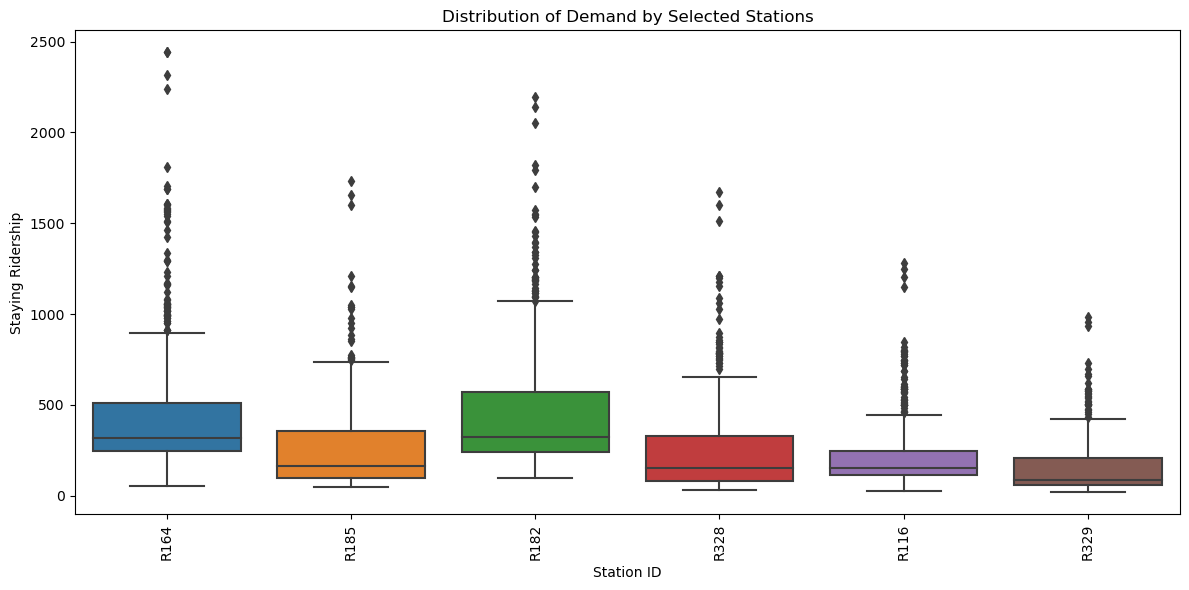

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
selected_stations = ['R164', 'R185', 'R182', 'R328', 'R116', 'R329'] 

selected_data = optimized_df[optimized_df['station_complex_id'].isin(selected_stations)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='station_complex_id', y='demand', data=selected_data, order=selected_stations)  # 使用order参数确保按指定顺序绘制
plt.title('Distribution of Demand by Selected Stations')
plt.xlabel('Station ID')
plt.ylabel('Staying Ridership')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
unique_station_ids = optimized_df['station_complex_id'].unique()

demand_min = optimized_df['demand'].min()
demand_max = optimized_df['demand'].max()

optimized_df['num_routes'] = optimized_df['routes'].str.split(',').apply(len)
num_routes_min = optimized_df['num_routes'].min()
num_routes_max = optimized_df['num_routes'].max()

print("Unique Station IDs:", unique_station_ids)
print("Demand Range: ({}, {})".format(demand_min, demand_max))
print("Number of Routes Range: ({}, {})".format(num_routes_min, num_routes_max))


Unique Station IDs: ['R192' 'R190' 'R188' 'R186' 'R185' 'R183' 'R182' 'R180' 'R178' 'R176'
 'R174' 'R173' 'R172' 'R170' 'R168' 'R164' 'R162' 'R160' 'N049' 'R154'
 'N060' 'R135' 'R133' 'R131' 'R129' 'N512' 'R125' 'R123' 'R119' 'R117'
 'R116' 'R106' 'R103' 'R101' 'R336' 'R335' 'R334' 'R333' 'R332' 'R331'
 'R330' 'R329' 'R328' 'R326' 'R325' 'R323' 'R322' 'R320' 'R318' 'R316'
 'R314' 'R312' 'R310' 'R261' 'R306' 'R304' 'R302' 'R301' 'R161B' 'N094'
 'N095' 'R111' 'R600' 'R602' 'R606' 'R608' 'R610' 'R617' 'R619' 'R621'
 'R622' 'R635' 'R636' 'R637' 'R639' 'R641' 'R643' 'R645']
Demand Range: (1.2, 17666.399999999998)
Number of Routes Range: (1, 17)


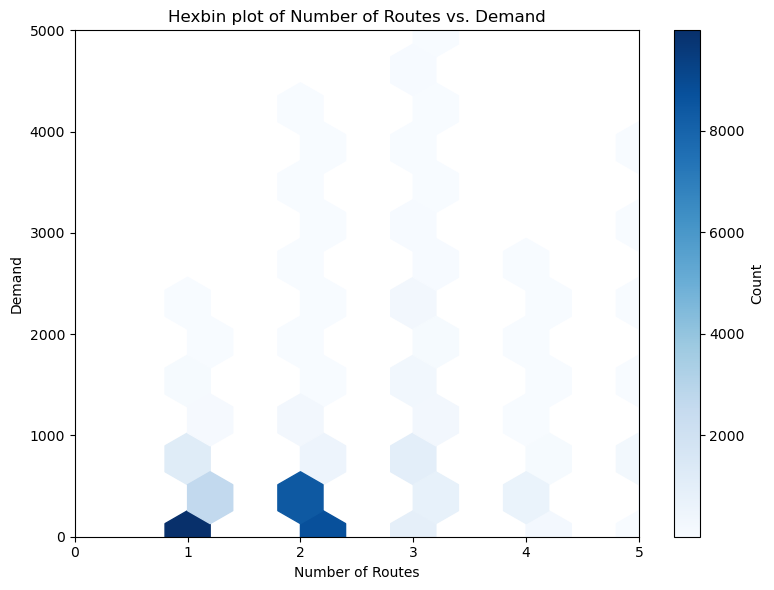

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

optimized_df['num_routes'] = optimized_df['routes'].str.split(',').apply(len)

plt.figure(figsize=(8, 6))
plt.hexbin(optimized_df['num_routes'], optimized_df['demand'], gridsize=40, cmap='Blues', mincnt=1)
plt.colorbar(label='Count')
plt.xlabel('Number of Routes')
plt.ylabel('Demand')
plt.xlim(0, 5)
plt.ylim(0, 5000)
plt.title('Hexbin plot of Number of Routes vs. Demand')
plt.tight_layout()
plt.show()



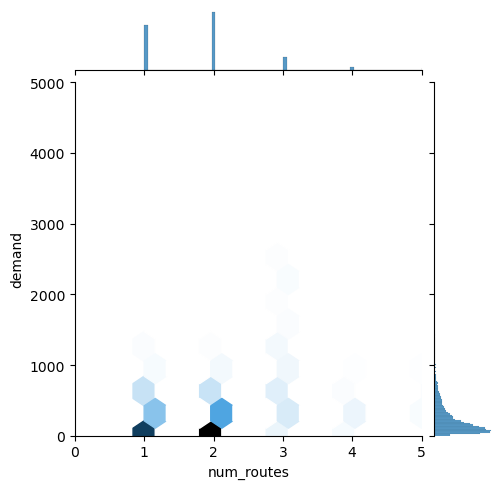

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

optimized_df['num_routes'] = optimized_df['routes'].str.split(',').apply(len)

g = sns.jointplot(x="num_routes", y="demand", data=optimized_df, kind="hex", height=5)
g.ax_joint.set_xlim(0, 5)
g.ax_joint.set_ylim(0, 5000)

plt.show()


In [35]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[optimized_df.iloc[0]['latitude'], optimized_df.iloc[0]['longitude']], zoom_start=12)

heat_data = [[row['latitude'], row['longitude'], row['demand']] for index, row in optimized_df.iterrows()]

HeatMap(heat_data).add_to(m)

m


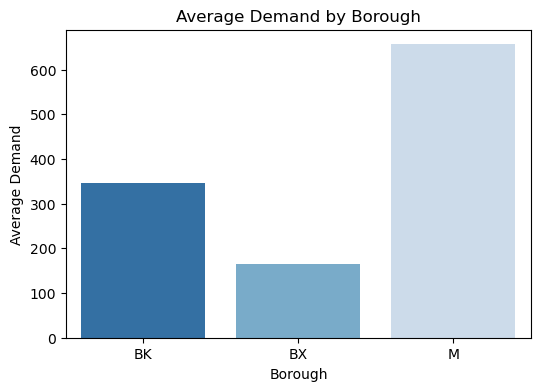

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

borough_demand_avg = optimized_df.groupby('borough')['demand'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='borough', y='demand', data=borough_demand_avg, palette='Blues_r')
plt.title('Average Demand by Borough')
plt.ylabel('Average Demand')
plt.xlabel('Borough')
plt.show()


In [22]:
id = pd.read_csv("id-D.csv")
id = id.iloc[:,:13]
id_tran = id.T
line_order = {}
for index, row in id_tran.iterrows():
    line_name = row.name
    stations = row.dropna().tolist()
    line_order[line_name] = stations
line_order

{'1': ['R101',
  'R103',
  'R106',
  'R116',
  'R117',
  'R119',
  'R123',
  'R125',
  'N512',
  'R129',
  'R131',
  'R133',
  'R135',
  'N060',
  'R154',
  'N049',
  'R160',
  'R161B',
  'R162',
  'R164',
  'R168',
  'R170',
  'R172',
  'R173',
  'R174',
  'R176',
  'R178',
  'R180',
  'R182',
  'R183',
  'R185',
  'R186',
  'R188',
  'R190',
  'R192',
  'R194',
  'R196',
  'R197'],
 '2': ['R645',
  'R643',
  'R641',
  'R639',
  'R637',
  'R636',
  'R635',
  'R622',
  'R621',
  'R619',
  'R617',
  'R610',
  'R608',
  'R606',
  'R602',
  'R600',
  'R111',
  'N095',
  'N094',
  'R116',
  'N512',
  'R135',
  'N060',
  'R161B',
  'R168',
  'R301',
  'R302',
  'R304',
  'R306',
  'R261',
  'R310',
  'R312',
  'R314',
  'R316',
  'R318',
  'R320',
  'R322',
  'R323',
  'R325',
  'R326',
  'R328',
  'R329',
  'R330',
  'R331',
  'R332',
  'R333',
  'R334',
  'R335',
  'R336'],
 '3': ['R634',
  'R633',
  'R632',
  'R630',
  'R629',
  'R628',
  'R627',
  'R626',
  'R624',
  'R623',
  'R622',
 

In [15]:
id_tran = id.T
id_tran2 = dict(id)
id_tran2

{'1': 0      R101
 1      R103
 2      R106
 3      R116
 4      R117
 5      R119
 6      R123
 7      R125
 8      N512
 9      R129
 10     R131
 11     R133
 12     R135
 13     N060
 14     R154
 15     N049
 16     R160
 17    R161B
 18     R162
 19     R164
 20     R168
 21     R170
 22     R172
 23     R173
 24     R174
 25     R176
 26     R178
 27     R180
 28     R182
 29     R183
 30     R185
 31     R186
 32     R188
 33     R190
 34     R192
 35     R194
 36     R196
 37     R197
 38      NaN
 39      NaN
 40      NaN
 41      NaN
 42      NaN
 43      NaN
 44      NaN
 45      NaN
 46      NaN
 47      NaN
 48      NaN
 Name: 1, dtype: object,
 '2': 0      R645
 1      R643
 2      R641
 3      R639
 4      R637
 5      R636
 6      R635
 7      R622
 8      R621
 9      R619
 10     R617
 11     R610
 12     R608
 13     R606
 14     R602
 15     R600
 16     R111
 17     N095
 18     N094
 19     R116
 20     N512
 21     R135
 22     N060
 23    R161B
 24     R168
 25

In [28]:
dataw = pd.read_csv("Wednesday.csv")
import folium
station_coords = dataw.groupby('station_complex_id')[['latitude', 'longitude']].mean()
print(line_order)

m = folium.Map(location=[40.730610, -73.935242], zoom_start=12)  

for line, stations in line_order.items():
    coords = []
    for station in stations:
        if station in station_coords.index:
            lat, lon = station_coords.loc[station]
            coords.append((lat, lon))
    if coords:  
        folium.PolyLine(coords, color='blue', weight=5, opacity=0.7).add_to(m)

m.save("NYC_Subway_Lines_total.html")


{'1': ['R101', 'R103', 'R106', 'R116', 'R117', 'R119', 'R123', 'R125', 'N512', 'R129', 'R131', 'R133', 'R135', 'N060', 'R154', 'N049', 'R160', 'R161B', 'R162', 'R164', 'R168', 'R170', 'R172', 'R173', 'R174', 'R176', 'R178', 'R180', 'R182', 'R183', 'R185', 'R186', 'R188', 'R190', 'R192', 'R194', 'R196', 'R197'], '2': ['R645', 'R643', 'R641', 'R639', 'R637', 'R636', 'R635', 'R622', 'R621', 'R619', 'R617', 'R610', 'R608', 'R606', 'R602', 'R600', 'R111', 'N095', 'N094', 'R116', 'N512', 'R135', 'N060', 'R161B', 'R168', 'R301', 'R302', 'R304', 'R306', 'R261', 'R310', 'R312', 'R314', 'R316', 'R318', 'R320', 'R322', 'R323', 'R325', 'R326', 'R328', 'R329', 'R330', 'R331', 'R332', 'R333', 'R334', 'R335', 'R336'], '3': ['R634', 'R633', 'R632', 'R630', 'R629', 'R628', 'R627', 'R626', 'R624', 'R623', 'R622', 'R621', 'R619', 'R617', 'R610', 'R608', 'R606', 'R602', 'R600', 'R111', 'N095', 'N094', 'R116', 'N512', 'R135', 'N060', 'R161B', 'R168', 'R301', 'R302', 'R304', 'R306', 'R308', 'R309'], '4': ['

In [8]:
wed[wed['station_complex'].str.startswith("125")]

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,itsuid,day
57,2022-08-31 02:00:00,R304,"125 St (2,3)",M,"3,2",omny,1,0,40.807755,-73.945496,POINT (-73.94549560546875 40.80775451660156),"2022-08-31T02:00:00R304125 St (2,3)M3,2omny",Wednesday
58,2023-04-05 04:00:00,R304,"125 St (2,3)",M,"3,2",omny,2,0,40.807755,-73.945496,POINT (-73.94549560546875 40.80775451660156),"2023-04-05T04:00:00R304125 St (2,3)M3,2omny",Wednesday
59,2023-04-12 07:00:00,R304,"125 St (2,3)",M,"3,2",omny,174,8,40.807755,-73.945496,POINT (-73.94549560546875 40.80775451660156),"2023-04-12T07:00:00R304125 St (2,3)M3,2omny",Wednesday
60,2023-04-19 22:00:00,R304,"125 St (2,3)",M,"3,2",omny,8,0,40.807755,-73.945496,POINT (-73.94549560546875 40.80775451660156),"2023-04-19T22:00:00R304125 St (2,3)M3,2omny",Wednesday
61,2023-05-10 00:00:00,R304,"125 St (2,3)",M,"3,2",omny,12,0,40.807755,-73.945496,POINT (-73.94549560546875 40.80775451660156),"2023-05-10T00:00:00R304125 St (2,3)M3,2omny",Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83976,2023-09-06 02:00:00,N026,"125 St (A,B,C,D)",M,"C,B,A,D",omny,20,0,40.811108,-73.952347,POINT (-73.95234680175781 40.81110763549805),"2023-09-06T02:00:00N026125 St (A,B,C,D)MC,B,A,...",Wednesday
83977,2023-09-20 03:00:00,N026,"125 St (A,B,C,D)",M,"C,B,A,D",omny,44,4,40.811108,-73.952347,POINT (-73.95234680175781 40.81110763549805),"2023-09-20T03:00:00N026125 St (A,B,C,D)MC,B,A,...",Wednesday
83979,2023-07-26 21:00:00,N026,"125 St (A,B,C,D)",M,"C,B,A,D",metrocard,1494,27,40.811108,-73.952347,POINT (-73.95234680175781 40.81110763549805),"2023-07-26T21:00:00N026125 St (A,B,C,D)MC,B,A,...",Wednesday
83983,2023-07-12 05:00:00,N026,"125 St (A,B,C,D)",M,"C,B,A,D",omny,180,15,40.811108,-73.952347,POINT (-73.95234680175781 40.81110763549805),"2023-07-12T05:00:00N026125 St (A,B,C,D)MC,B,A,...",Wednesday


In [9]:
remote_id = 'A041'
date = "2022-07-06"
remote_id_df = wed[wed['station_complex_id']==remote_id]

In [10]:
test = remote_id_df[remote_id_df['transit_timestamp'].str.startswith(date)]
test = remote_id_df

AttributeError: Can only use .str accessor with string values!

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df =test

# Convert string to datetime format and extract hour
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df['hour'] = df['transit_timestamp'].dt.hour


# Group by hour and count the number of riders
hourly_ridership = df.groupby('hour').sum('ridership')
hourly_ridership = hourly_ridership.reset_index()
hourly_ridership



plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_ridership, x='hour', y='ridership')
plt.title('Ridership Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Riders')
plt.show()


In [ ]:
wed['transit_timestamp'] = pd.to_datetime(wed['transit_timestamp'])

# Filter rows with time between 4:00 AM and 9:00 AM
filtered_df = wed[(wed['transit_timestamp'].dt.time >= pd.to_datetime('11:00:00').time()) & 
                 (wed['transit_timestamp'].dt.time <= pd.to_datetime('12:00:00').time())]

filtered_df

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Sample dataset

df = filtered_df

# Create a map centered around NYC
nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12)

# Generate heatmap
heat_data = [[row['latitude'], row['longitude'], row['ridership']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(nyc_map)

# nyc_map.save("nyc_ridership_heatmap.html")


In [ ]:
# wed['transit_timestamp'] = pd.to_datetime(wed['transit_timestamp'])

# # Filter rows with time between 4:00 AM and 9:00 AM
# filtered_df = wed[(wed['transit_timestamp'].dt.time >= pd.to_datetime('15:00:00').time()) &
#                   (wed['transit_timestamp'].dt.time <= pd.to_datetime('19:00:00').time())]

# filtered_df
# import folium
# from folium.plugins import HeatMap
# import pandas as pd

# # Sample dataset

# df = filtered_df

# # Create a map centered around NYC
# nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12)

# # Generate heatmap
# heat_data = [[row['latitude'], row['longitude'], pow(row['ridership'],0.7)] for index, row in df.iterrows()]
# HeatMap(heat_data).add_to(nyc_map)

# # nyc_map.save("nyc_ridership_heatmap.html")

# nyc_map.save("nyc_ridership_heatmap_after.html")

In [ ]:
list(wed['routes'].unique())

In [ ]:
data ={'Z': 13509096,
 'J': 14968933,
 'W': 40448788,
 '1': 42024911,
#  'Q': 39690076,
 'L': 20718885,
 'C': 45655842,
 'S': 18551041,
 '3': 37889570,
 '5': 30596052,
 'G': 9223454,
 'E': 36789891,
 'B': 43722127,
 'A': 41004281,
 'M': 43517850,
 'F': 46283300,
 'D': 40067474,
 'R': 55681600,
 '6': 33163028,
 '2': 41107004,
 '7': 34579130,
 '4': 31090427,
 'N': 40108508,
 'SIR': 134855}
data_dict = dict(sorted(data.items()))
print(len(data_dict))

labels = list(data_dict.keys())
sizes = list(data_dict.values())
colors = plt.cm.YlGnBu([float(i)/max(sizes) for i in sizes])

# # 创建饼状图
# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.title('Sample Pie Chart')
# plt.axis('equal')  # 使饼状图呈现为圆形

# plt.show()
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance=0.85,
        colors=colors, wedgeprops=dict(width=0.5))
# plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance=0.85,
#         wedgeprops=dict(width=0.5))
plt.title('Ridership of Each Routes')
plt.axis('equal')

plt.show()

NameError: name 'df' is not defined